In [1]:
import networkx as nx
import pandas as pd
import ast
import matplotlib.pyplot as plt

## Recipe Graph

In [2]:
def create_recipe_ingredient_graph(recipes_df, min_common_ingredients=2):
    if isinstance(recipes_df['ingredients'].iloc[0], str):
        recipes_df['ingredients'] = recipes_df['ingredients'].apply(ast.literal_eval)
    G = nx.Graph()

    for _, row in recipes_df.iterrows():
        G.add_node(
            row['id'], 
            name=row['name'], 
            num_ingredients=len(row['ingredients']),
            ingredients=row['ingredients']
        )
    
    for i in range(len(recipes_df)):
        for j in range(i+1, len(recipes_df)):
            ingredients1 = set(recipes_df['ingredients'].iloc[i])
            ingredients2 = set(recipes_df['ingredients'].iloc[j])
          
            common_ingredients = ingredients1.intersection(ingredients2)
    
            if len(common_ingredients) >= min_common_ingredients:
                G.add_edge(
                    recipes_df['id'].iloc[i], 
                    recipes_df['id'].iloc[j], 
                    weight=len(common_ingredients),
                    common_ingredients=list(common_ingredients)
                )
    
    return G

In [3]:
def get_recipe_by_id(G, recipe_id):
    if recipe_id not in G.nodes():
        raise ValueError(f"Recipe ID {recipe_id} not found in the graph")
    
    node_data = G.nodes[recipe_id]
    return {
        'id': recipe_id,
        'name': node_data.get('name', 'Unknown'),
        'num_ingredients': node_data.get('num_ingredients', 0),
        'ingredients': node_data.get('ingredients', [])
    }


In [4]:
def find_most_connected_recipes(G, top_n=10):

    degrees = dict(G.degree())
    
    top_recipes = sorted(
        [(node, degree, G.nodes[node]['name']) for node, degree in degrees.items()], 
        key=lambda x: x[1], 
        reverse=True
    )[:top_n]
    
    return [
        {
            'id': recipe[0], 
            'connections': recipe[1], 
            'name': recipe[2]
        } 
        for recipe in top_recipes
    ]


In [5]:
def analyze_recipe_ingredient_graph(G):
    return {
        'num_nodes': G.number_of_nodes(),
        'num_edges': G.number_of_edges(),
        'avg_degree': sum(dict(G.degree()).values()) / G.number_of_nodes(),
        'density': nx.density(G),
        'connected_components': nx.number_connected_components(G)
    }

In [6]:
recipes_df = pd.read_csv(r'recipes/RAW_recipes.csv')

In [7]:
recipes_df_small = recipes_df.head(500)

In [8]:
G_default = create_recipe_ingredient_graph(recipes_df_small, min_common_ingredients=2)
    
G_stricter = create_recipe_ingredient_graph(recipes_df_small, min_common_ingredients=5)
   
print("Default Graph Analysis (2 common ingredients):")
print(analyze_recipe_ingredient_graph(G_default))
    
print("\nStricter Graph Analysis (3 common ingredients):")
print(analyze_recipe_ingredient_graph(G_stricter))


C:\Users\Ákos\AppData\Local\Temp\ipykernel_54080\1874502687.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recipes_df['ingredients'] = recipes_df['ingredients'].apply(ast.literal_eval)


Default Graph Analysis (2 common ingredients):
{'num_nodes': 500, 'num_edges': 13253, 'avg_degree': 53.012, 'density': 0.10623647294589178, 'connected_components': 47}

Stricter Graph Analysis (3 common ingredients):
{'num_nodes': 500, 'num_edges': 619, 'avg_degree': 2.476, 'density': 0.0049619238476953905, 'connected_components': 377}


In [9]:
nx.write_gml(G_default, 'recipe_graph_2_common_ingredients.gml')
nx.write_gml(G_stricter, 'recipe_graph_5_common_ingredients.gml')

In [10]:
def visualize_graph(G, top_n=100, label_threshold=None):

    degrees = dict(G.degree())
    top_nodes = sorted(degrees, key=degrees.get, reverse=True)[:top_n]
    
    H = G.subgraph(top_nodes)
    
    if label_threshold is None:
        sorted_degrees = sorted(degrees.values(), reverse=True)
        label_threshold = sorted_degrees[min(int(top_n * 0.2), len(sorted_degrees)-1)]
    
    plt.figure(figsize=(24,24))
    
    pos = nx.spring_layout(H, k=0.5, iterations=50, seed=42)
    
    node_sizes = [degrees[node]*20 for node in H.nodes()]
    node_colors = ['lightblue' if degrees[node] < label_threshold else 'salmon' for node in H.nodes()]
    
    nx.draw_networkx_nodes(H, pos, 
                            node_color=node_colors, 
                            node_size=node_sizes)
    
    nx.draw_networkx_edges(H, pos, 
                            width=0.3, 
                            alpha=0.5)
    
    labels = {
        node: G.nodes[node]['name'] 
        for node in H.nodes() 
        if degrees[node] >= label_threshold
    }
    nx.draw_networkx_labels(H, pos, 
                             labels, 
                             font_size=8, 
                             font_weight="bold")
    
    plt.title(f"Recipe Ingredient Graph - Top {top_n} Nodes (Labeled Nodes with Degree ≥ {label_threshold})")
    plt.axis('off')
    
    return plt.gcf()

C:\Users\Ákos\AppData\Local\Temp\ipykernel_54080\3708480323.py:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  visualize_graph(G_default).show()


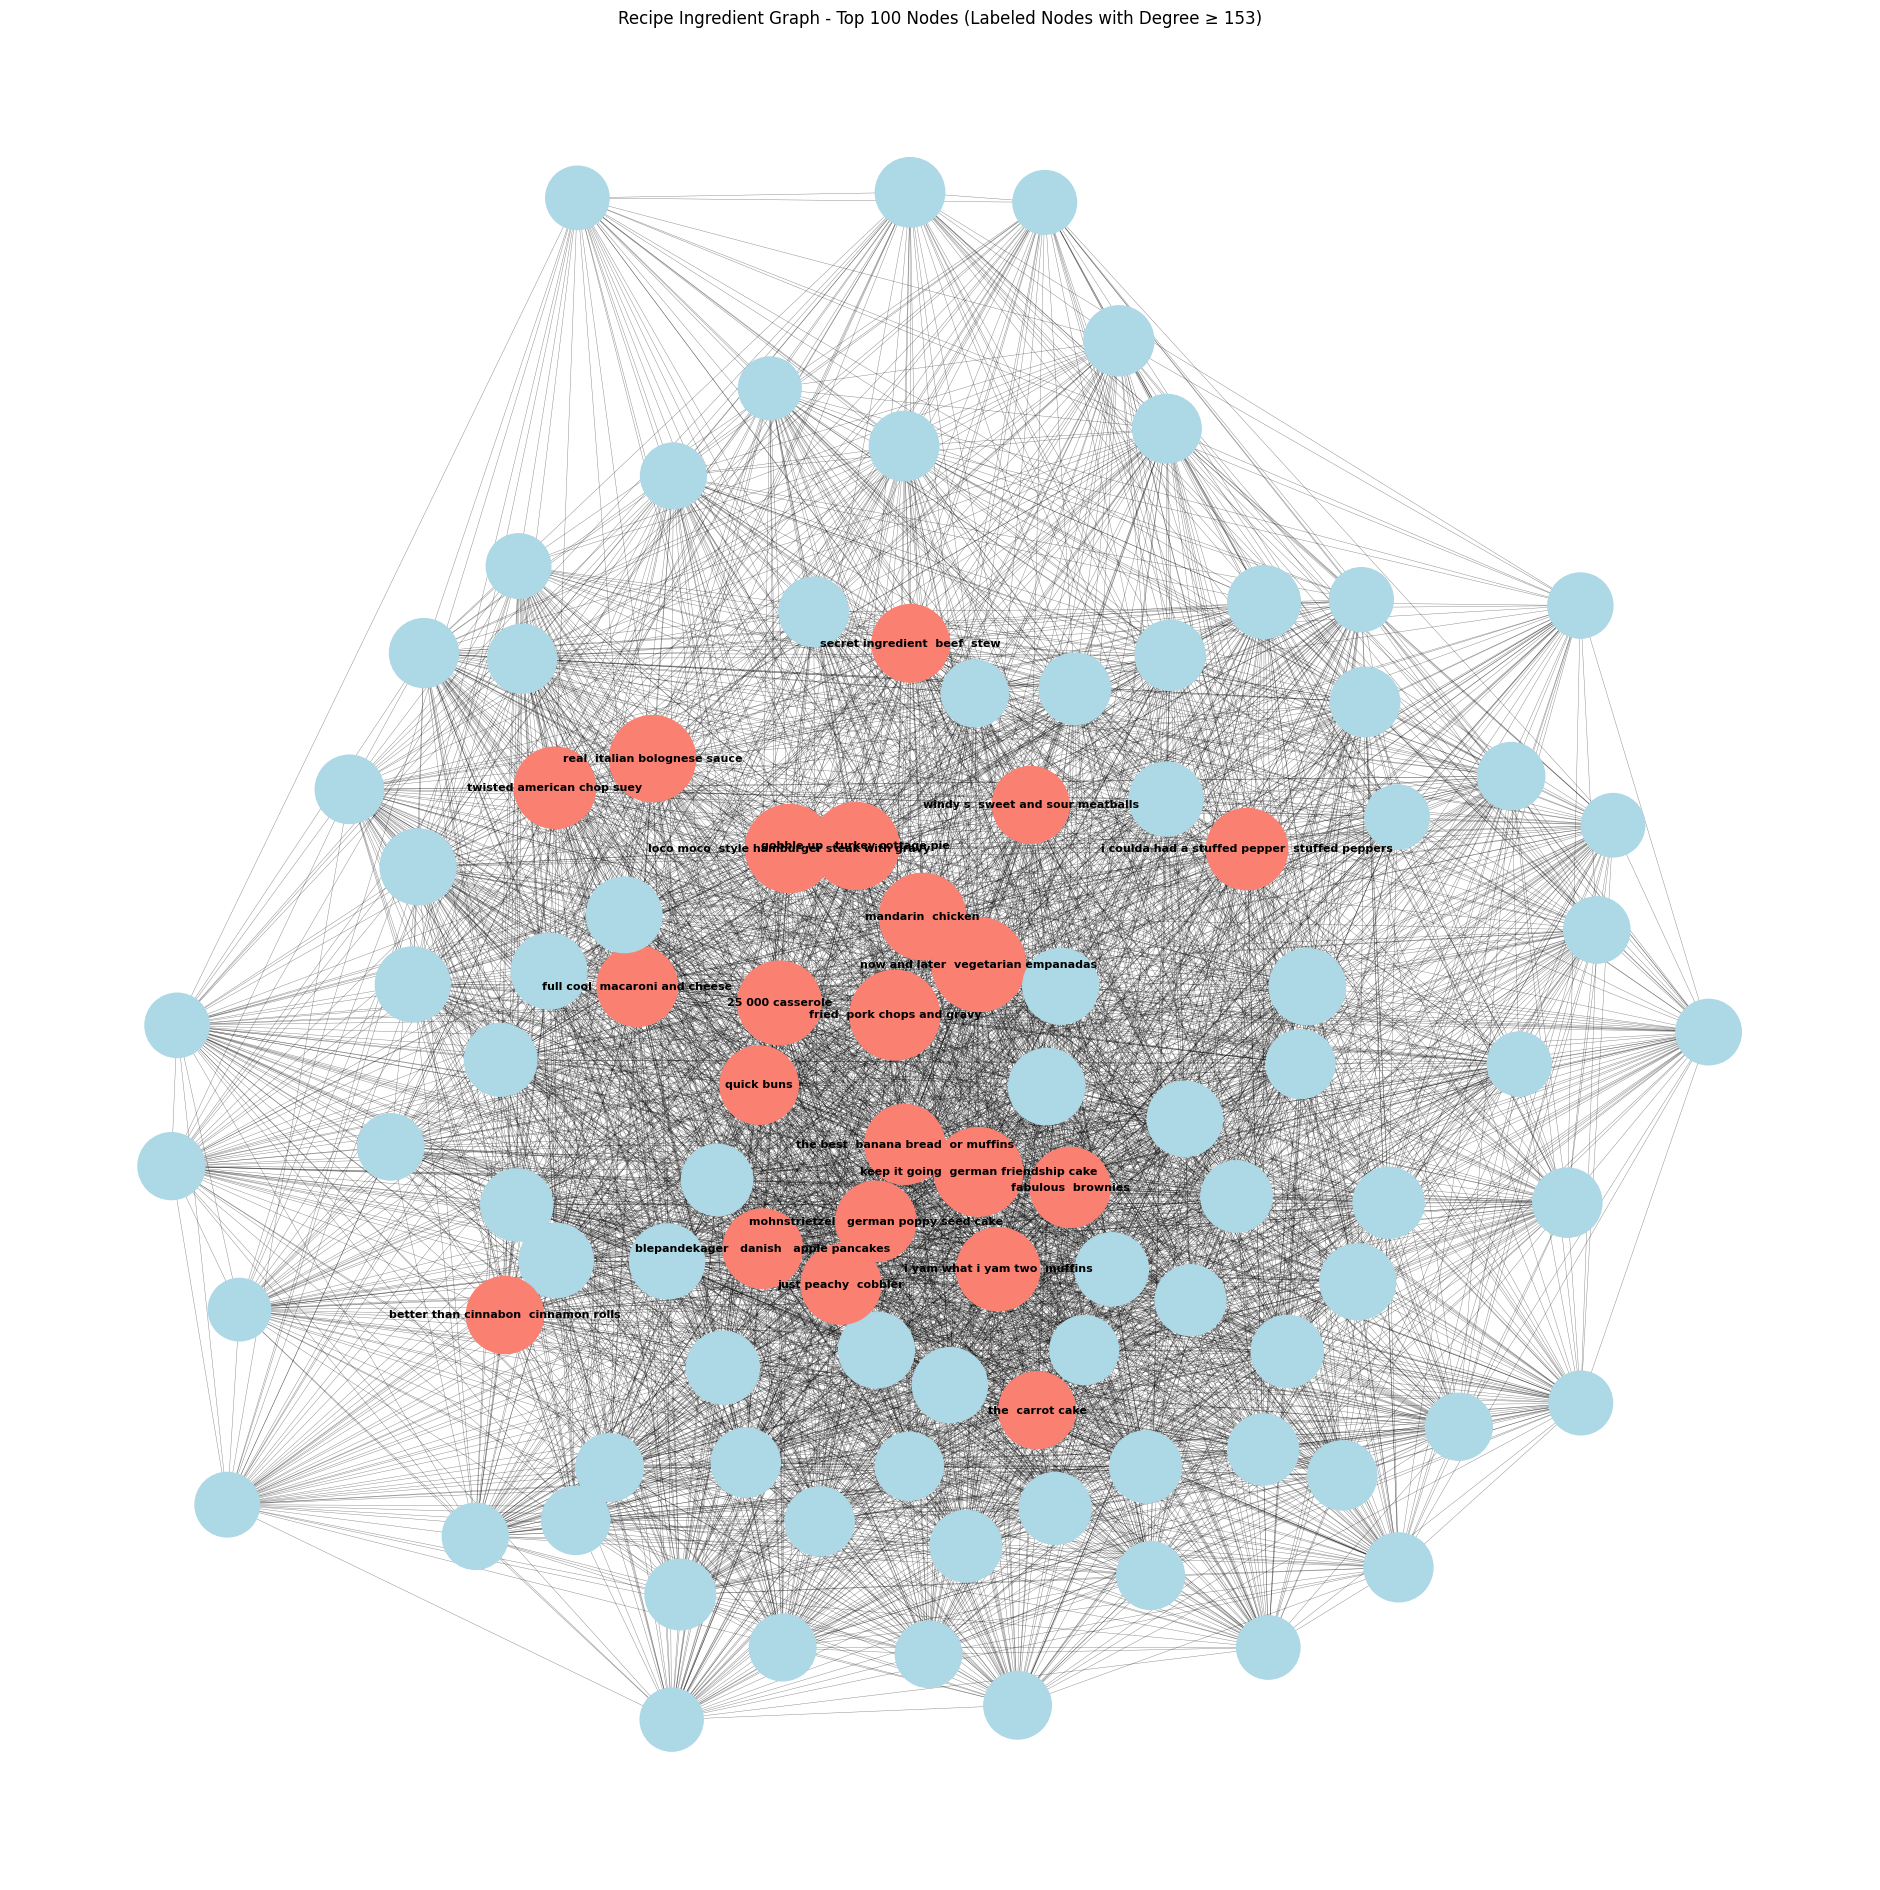

In [11]:
visualize_graph(G_default).show()

C:\Users\Ákos\AppData\Local\Temp\ipykernel_54080\3370141386.py:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  visualize_graph(G_stricter).show()


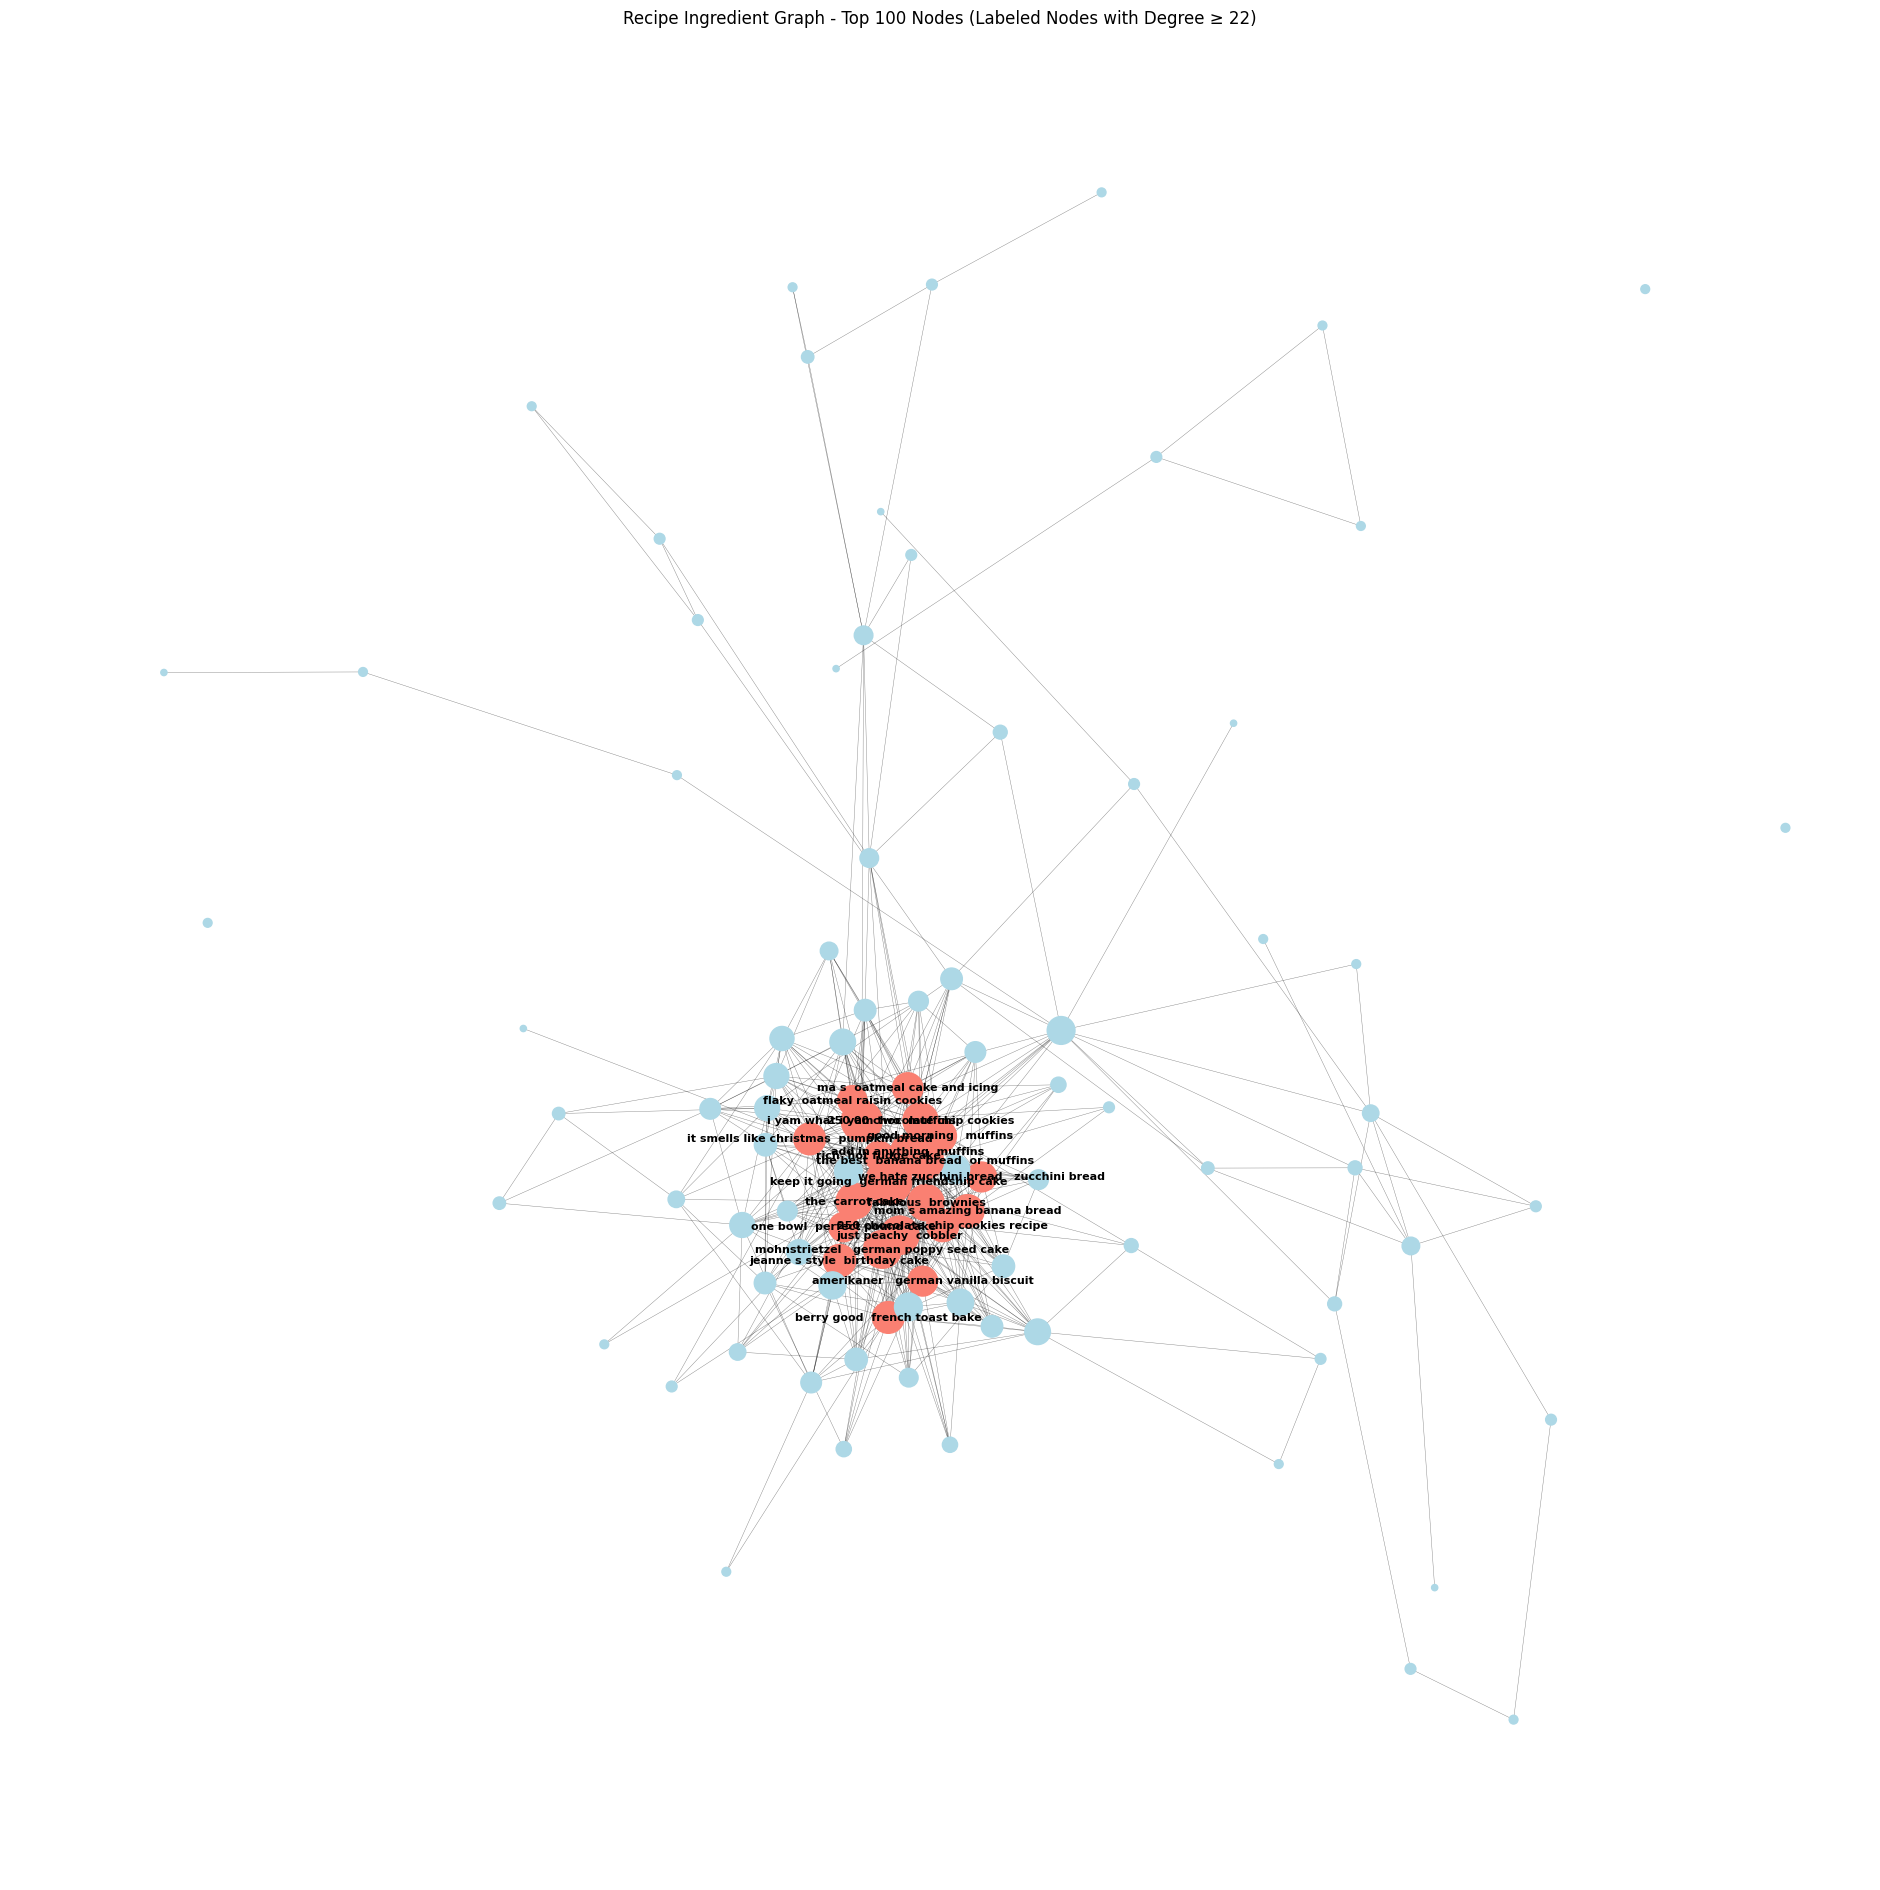

In [12]:
visualize_graph(G_stricter).show()

## What are the most versatile or influential recipes based on their graph connectivity?

In [84]:
import networkx as nx

def compute_centralities(graph):
    degree_centrality = nx.degree_centrality(graph)
    betweenness_centrality = nx.betweenness_centrality(graph)
    closeness_centrality = nx.closeness_centrality(graph)
    eigenvector_centrality = nx.eigenvector_centrality(graph)
    
    return {
        'degree': degree_centrality,
        'betweenness': betweenness_centrality,
        'closeness': closeness_centrality,
        'eigenvector': eigenvector_centrality
    }

def get_top_recipes(centralities, centrality_type='degree', top_n=10):
    if centrality_type not in centralities:
        raise ValueError("Invalid centrality type. Choose from ['degree', 'betweenness', 'closeness', 'eigenvector']")
    
    sorted_centralities = sorted(centralities[centrality_type].items(), key=lambda x: x[1], reverse=True)
    #use node name instead of id
    sorted_centralities = [(G_default.nodes[node]['name'], centrality) for node, centrality in sorted_centralities]
    return sorted_centralities[:top_n] 


from collections import Counter

def get_top_recipes_by_frequency(centralities, top_n=5):
    all_top_recipes = []
    
    for centrality_type in ['degree', 'betweenness', 'closeness', 'eigenvector']:
        top_recipes = get_top_recipes(centralities, centrality_type=centrality_type, top_n=top_n)
        all_top_recipes.extend([recipe[0] for recipe in top_recipes]) 
    
    recipe_counts = Counter(all_top_recipes)
    
    top_recipes_by_frequency = recipe_counts.most_common(top_n)
    
    return top_recipes_by_frequency



In [71]:
graphs = {
    "default": G_default,
    "stricter": G_stricter,
    # Add other graphs as needed
}

In [86]:
for graph_name, graph in graphs.items():
    print(f"\nProcessing graph: {graph_name}")
    
    centralities = compute_centralities(graph)
    print(f"Centralities for {graph_name}: {centralities}")
    
    # top_degree = get_top_recipes(centralities, centrality_type='degree', top_n=10)
    # top_betweenness = get_top_recipes(centralities, centrality_type='betweenness', top_n=10)
    # top_closeness = get_top_recipes(centralities, centrality_type='closeness', top_n=10)
    # top_eigenvector = get_top_recipes(centralities, centrality_type='eigenvector', top_n=10)

    top_recipes_by_frequency = get_top_recipes_by_frequency(centralities, top_n=5)
    print(f"Top Recipes by Frequency across Centralities in {graph_name}:")
    for recipe, count in top_recipes_by_frequency:
        print(f"{recipe}: {count} times")
    

    


Processing graph: default
Centralities for default: {'degree': {137739: 0.13827655310621242, 31490: 0.06412825651302605, 112140: 0.1503006012024048, 59389: 0.14629258517034066, 44061: 0.18837675350701402, 5289: 0.002004008016032064, 25274: 0.01002004008016032, 67888: 0.22044088176352702, 70971: 0.002004008016032064, 75452: 0.1903807615230461, 109439: 0.0, 42198: 0.09819639278557113, 67547: 0.2545090180360721, 107517: 0.05611222444889779, 39959: 0.0, 63986: 0.1442885771543086, 43026: 0.0060120240480961915, 23933: 0.0, 8559: 0.05410821643286573, 23850: 0.1062124248496994, 76808: 0.10821643286573146, 24701: 0.16633266533066132, 83873: 0.0721442885771543, 107699: 0.30260521042084165, 49262: 0.11222444889779558, 48156: 0.0060120240480961915, 54272: 0.17434869739478956, 47366: 0.19639278557114226, 37073: 0.0, 44123: 0.1222444889779559, 27087: 0.2685370741482966, 59952: 0.19639278557114226, 93249: 0.004008016032064128, 54100: 0.19639278557114226, 67664: 0.0, 87098: 0.012024048096192383, 2577

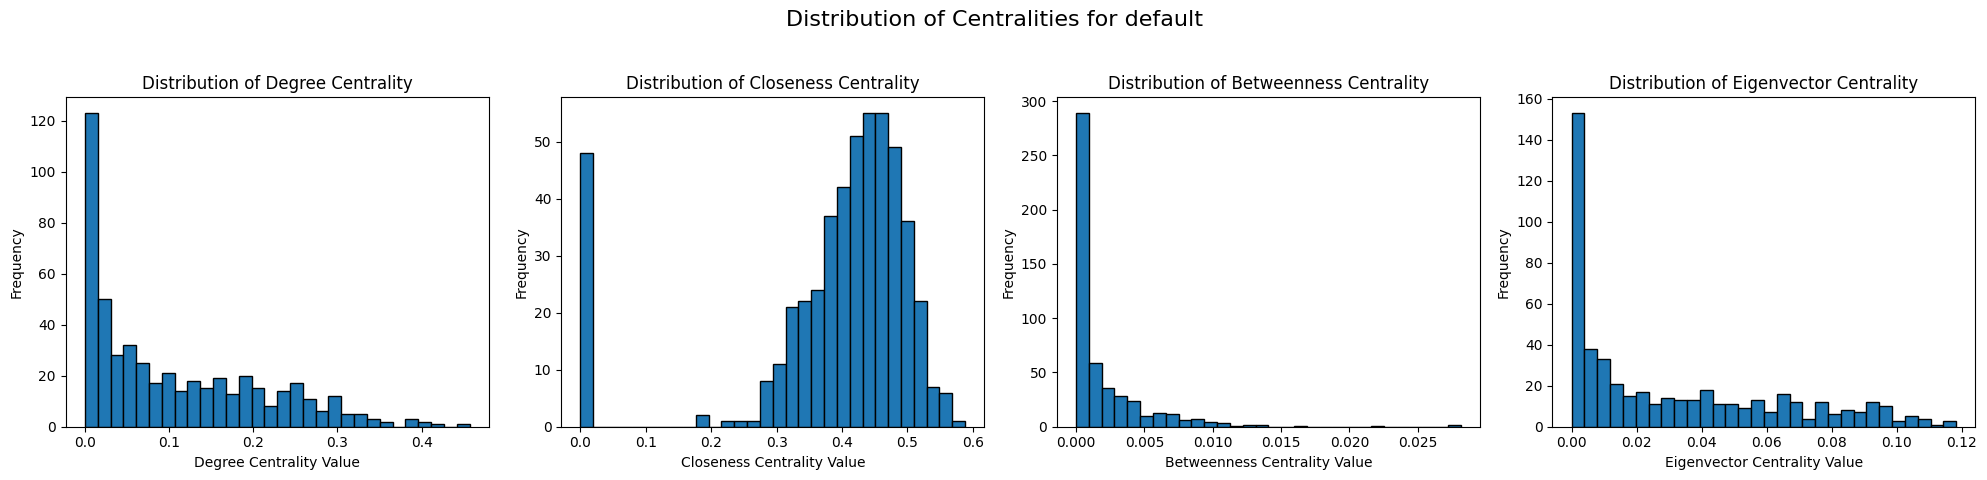

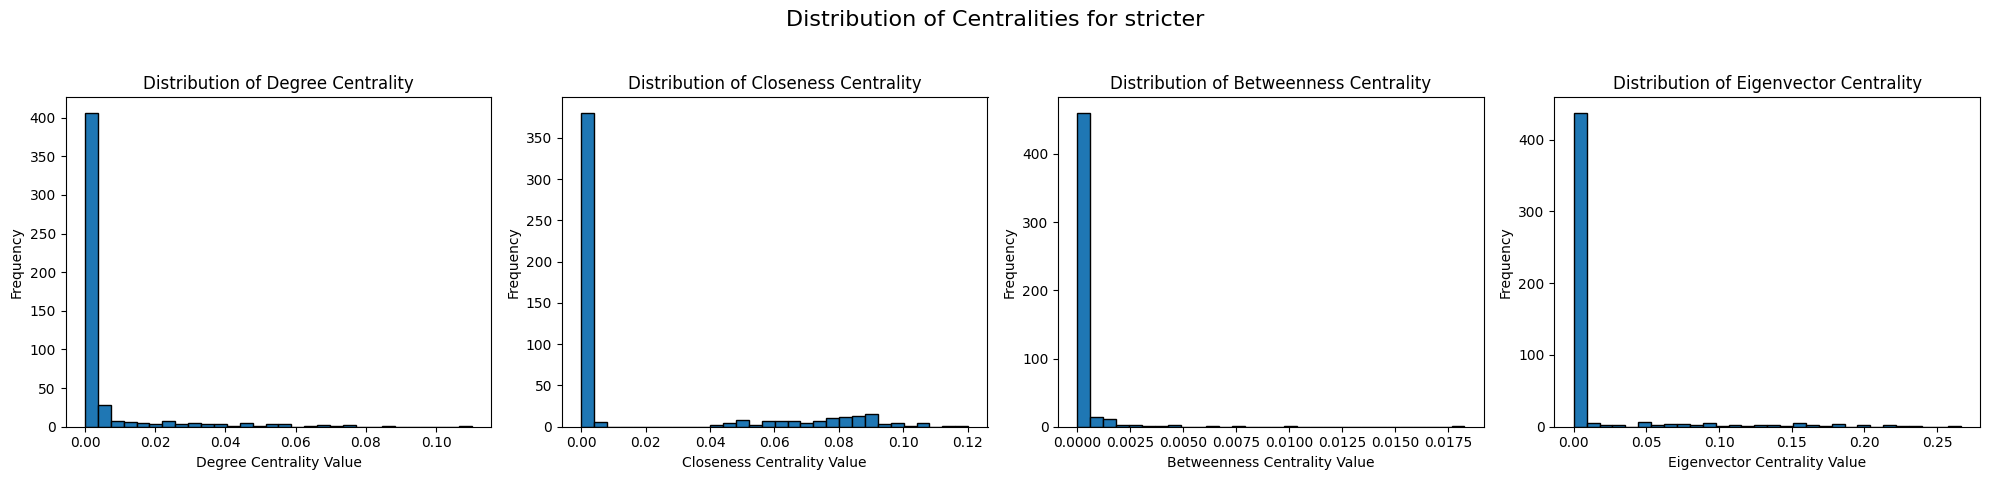

In [87]:
def plot_centrality_distributions(df, graph_name):
    centrality_types = ['degree', 'closeness', 'betweenness', 'eigenvector']
    titles = [
        'Degree Centrality',
        'Closeness Centrality',
        'Betweenness Centrality',
        'Eigenvector Centrality'
    ]

    # Create subplots
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))

    for ax, centrality_type, title in zip(axes, centrality_types, titles):
        ax.hist(df[centrality_type], bins=30, edgecolor='black')
        ax.set_title(f'Distribution of {title}')
        ax.set_xlabel(f'{title} Value')
        ax.set_ylabel('Frequency')

    plt.suptitle(f'Distribution of Centralities for {graph_name}', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
    plt.show()

for graph_name, graph in graphs.items():
    centralities = compute_centralities(graph)
    df = pd.DataFrame(centralities)
    plot_centrality_distributions(df, graph_name)

## Extra calculations

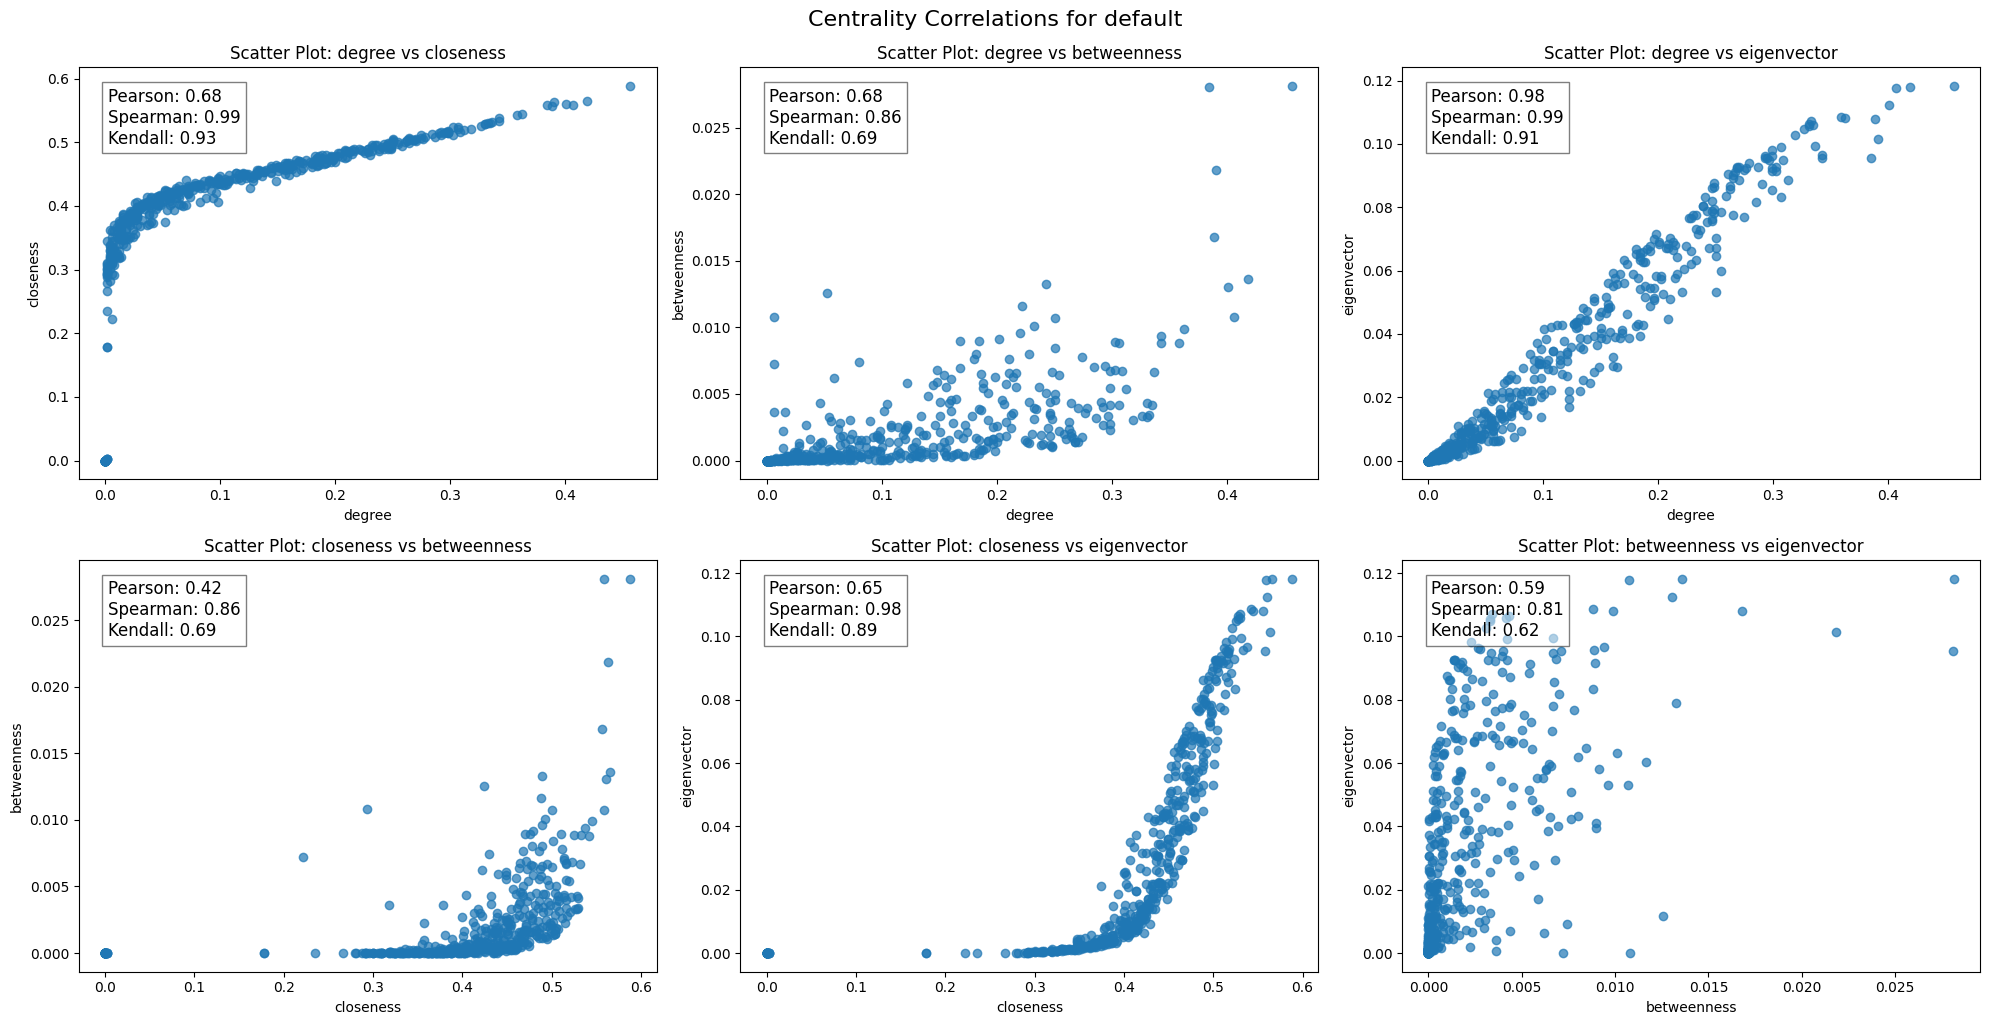

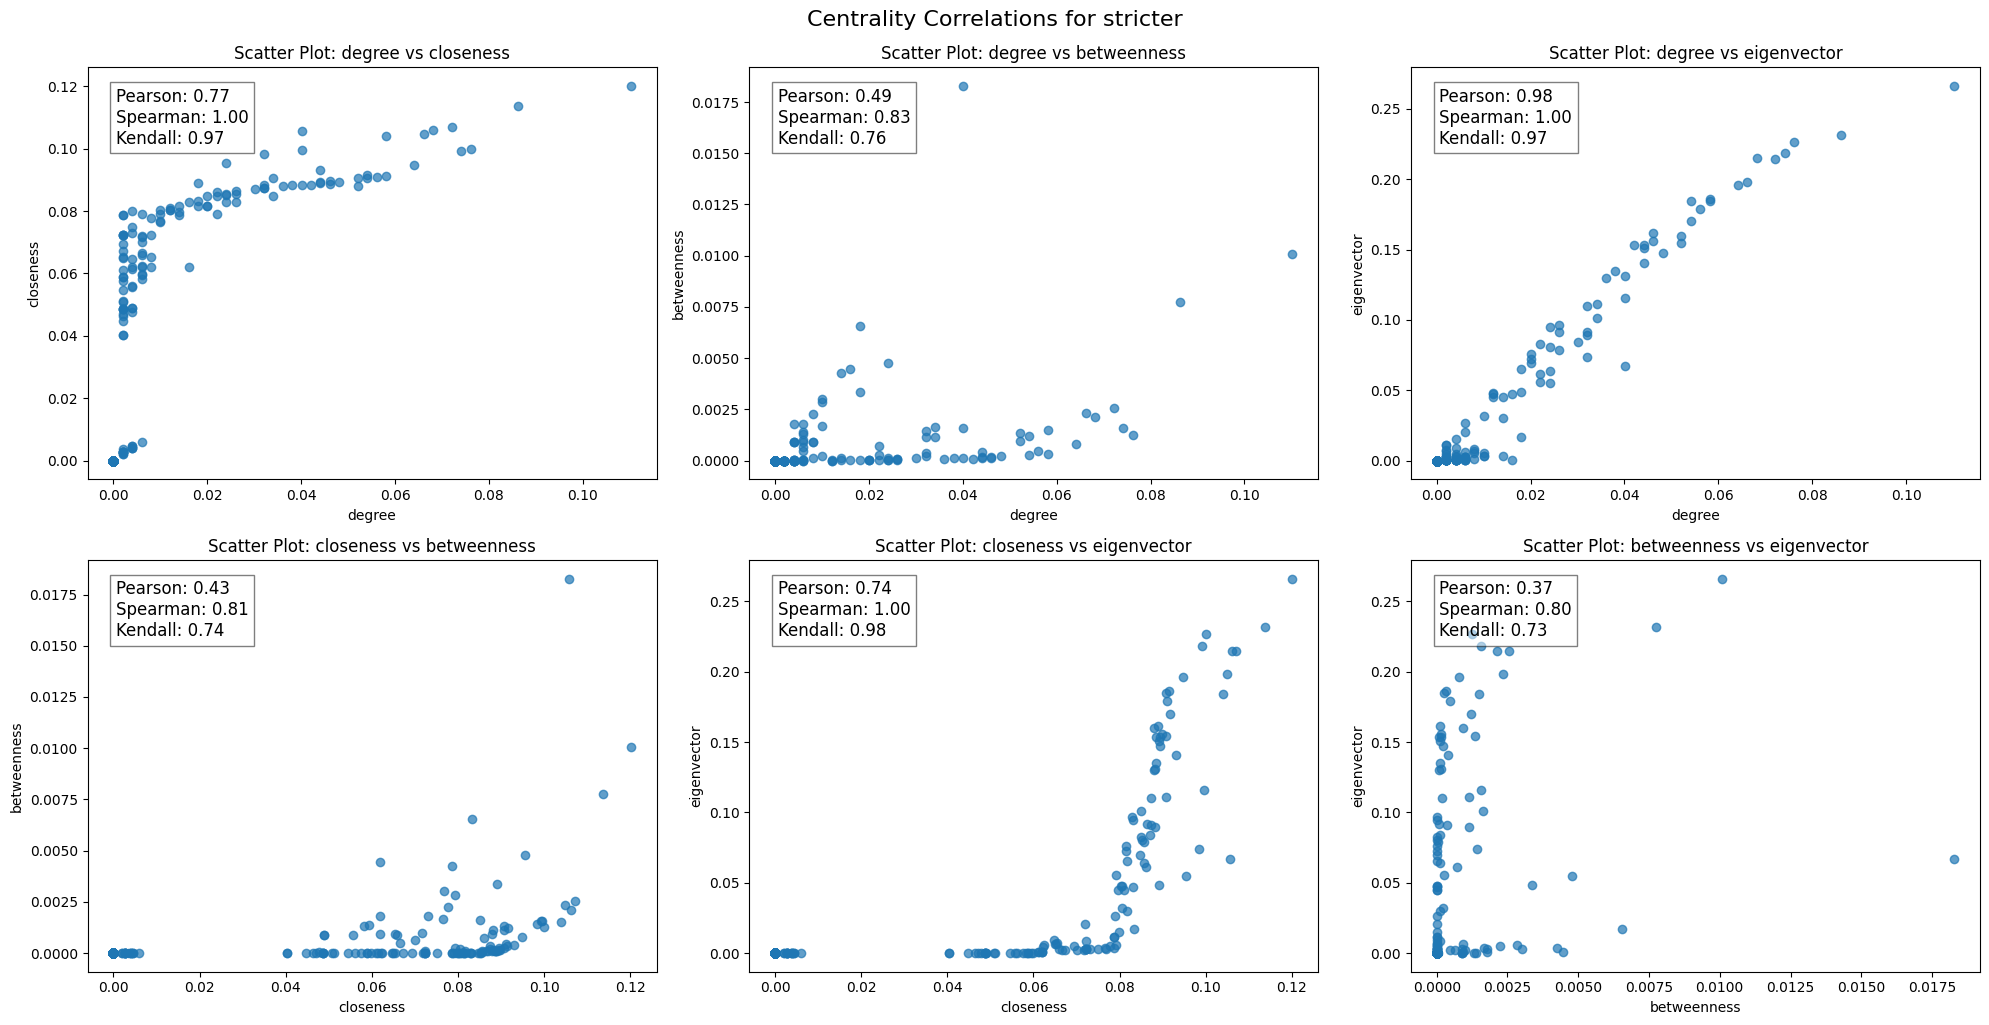

In [88]:
from scipy.stats import pearsonr, spearmanr, kendalltau


def compute_correlation(df, col1, col2):
    pearson_corr, _ = pearsonr(df[col1], df[col2])
    spearman_corr, _ = spearmanr(df[col1], df[col2])
    kendall_corr, _ = kendalltau(df[col1], df[col2])
    return pearson_corr, spearman_corr, kendall_corr

def plot_centrality_scatter_plots(df, graph_name):
    centrality_columns = [
        'degree',
        'closeness',
        'betweenness',
        'eigenvector'
    ]
    
    # We created a grid for the scatter plots
    fig, axes = plt.subplots(2, 3, figsize=(20, 10))
    axes = axes.flatten()  
    
    plot_index = 0
    for i in range(len(centrality_columns)):
        for j in range(i + 1, len(centrality_columns)):
            col1 = centrality_columns[i]
            col2 = centrality_columns[j]
            
            # Compute correlations
            pearson_corr, spearman_corr, kendall_corr = compute_correlation(df, col1, col2)
            
            # Scatter plot using matplotlib
            axes[plot_index].scatter(df[col1], df[col2], alpha=0.7)
            axes[plot_index].set_title(f'Scatter Plot: {col1} vs {col2}')
            axes[plot_index].set_xlabel(col1)
            axes[plot_index].set_ylabel(col2)
            
            # Annotate correlation coefficients
            axes[plot_index].text(0.05, 0.95, f'Pearson: {pearson_corr:.2f}\nSpearman: {spearman_corr:.2f}\nKendall: {kendall_corr:.2f}', 
                                   transform=axes[plot_index].transAxes, fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))
            
            plot_index += 1

    plt.tight_layout()
    plt.suptitle(f'Centrality Correlations for {graph_name}', fontsize=16, y=1.02)
    plt.show()


for graph_name, graph in graphs.items():
    centralities = compute_centralities(graph)
    df = pd.DataFrame(centralities)
    plot_centrality_scatter_plots(df, graph_name)

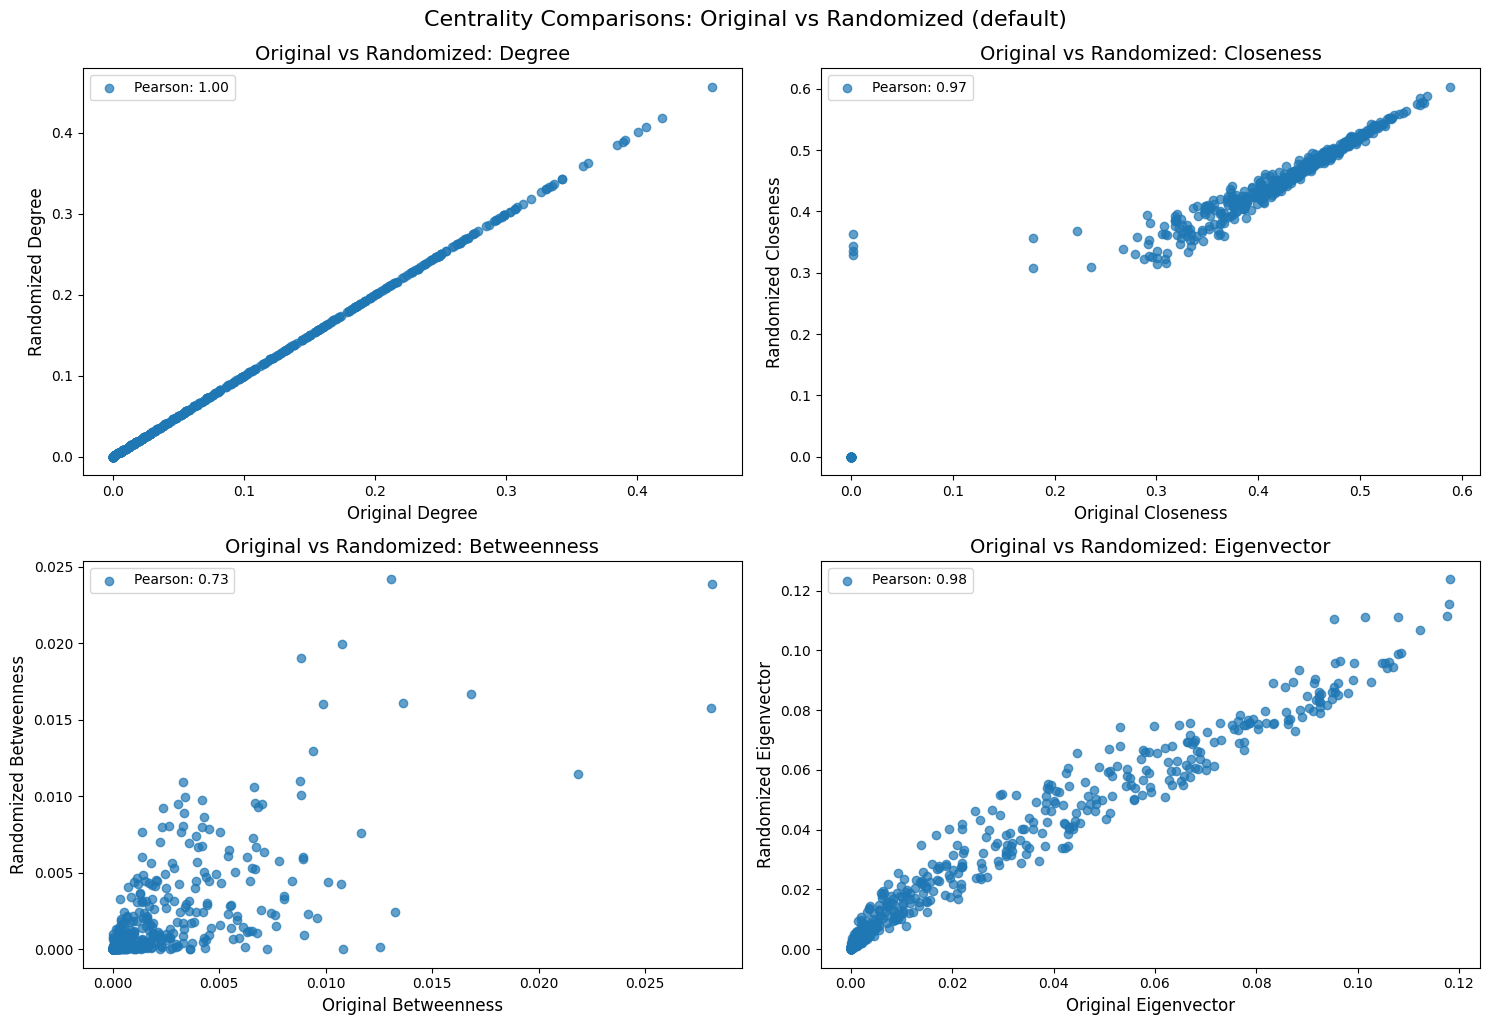

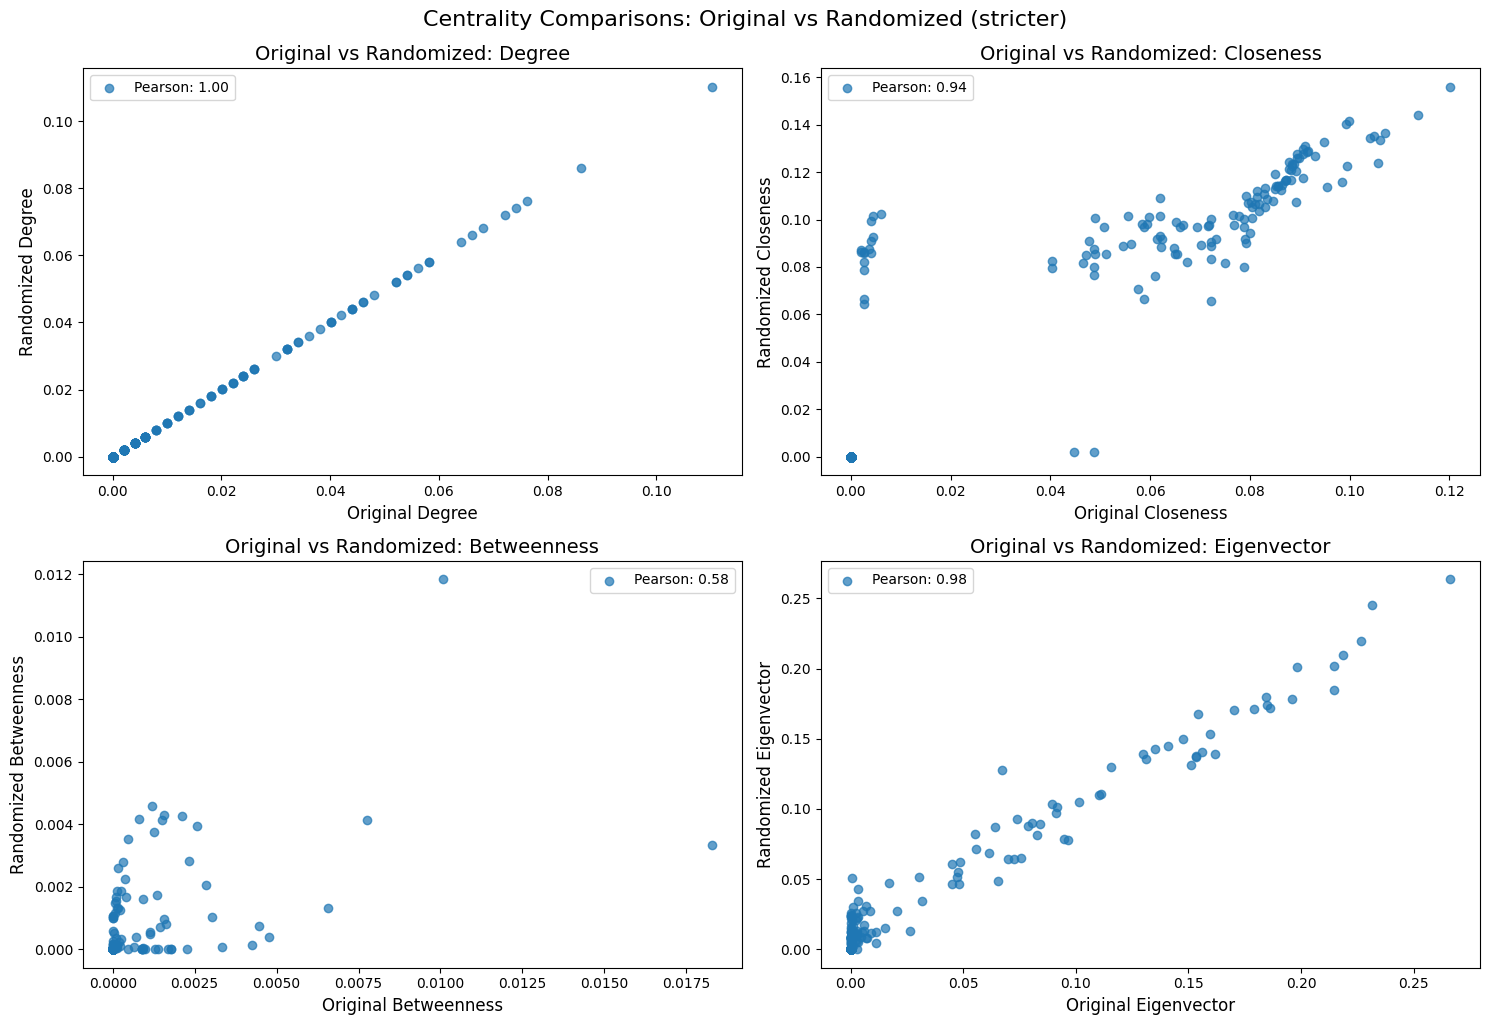

In [ ]:
from scipy.stats import pearsonr

def randomize_graph(graph):
    randomized_graph = nx.algorithms.smallworld.random_reference(graph, connectivity=False)
    return randomized_graph

def compute_pearson(df1, df2, col):
    return pearsonr(df1[col], df2[col])[0]

# This function plots the scatter plots for each centrality type, comparing the original and randomized graphs.
def plot_centrality_comparisons(df_original, df_randomized, graph_name):
    centrality_types = ['degree', 'closeness', 'betweenness', 'eigenvector']
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()

    for i, centrality in enumerate(centrality_types):
        pearson_corr = compute_pearson(df_original, df_randomized, centrality)
        
        # Scatter plot for original vs randomized
        axes[i].scatter(df_original[centrality], df_randomized[centrality], alpha=0.7, label=f'Pearson: {pearson_corr:.2f}')
        axes[i].set_title(f'Original vs Randomized: {centrality.capitalize()}', fontsize=14)
        axes[i].set_xlabel(f'Original {centrality.capitalize()}', fontsize=12)
        axes[i].set_ylabel(f'Randomized {centrality.capitalize()}', fontsize=12)
        axes[i].legend()
    
    plt.tight_layout()
    plt.suptitle(f'Centrality Comparisons: Original vs Randomized ({graph_name})', fontsize=16, y=1.02)
    plt.show()

for graph_name, graph in graphs.items():
    centralities = compute_centralities(graph)
    df = pd.DataFrame(centralities)
    
    randomized_graph = randomize_graph(graph)
    randomized_centralities = compute_centralities(randomized_graph)
    df_randomized = pd.DataFrame(randomized_centralities)
    
    plot_centrality_comparisons(df, df_randomized, graph_name)

### Observations

We can see on the plots that the Degree Centrality remains unchanged in the randomized graphs, because the degree distribution is preserved by the randomization. In case of Closeness and Betweenness Centrality we can see a lower correlation because randomization disrupts the shortest-path and flow structures. The Eigenvector Centrality also shows lower correlations but the difference is smaller, depending on how connected the nodes are in the random graph versus the original.

  
#### 1. Degree Centrality
Degree centrality measures the number of direct connections a node has within the network. In real-world, for example in a social network, a user with a high degree centrality is well-connected meaning it has many friends, or in an airline network an airport with high degree centrality has connections to many destinations.

During the randomization the edges are randomly rewired, but the node degrees remain unchanged, so the degree distribution remains the same, and therefore, the Degree Centrality remains unchanged, as the total number of connections for each node remained constant. Thats why it has 1.0 correlation.

#### 2. Closeness Centrality
Closeness centrality reflects how quickly a node can access other nodes in the network, measured by the average shortest path from that node to all others. 

Closeness Centrality shows lower correlation because overall the shortest paths are disrupted because of the randomization. It can create new shortest paths, but overall it reshuffles the natural structure that real-world networks have and disrupts a carefully desinged network like the airline network. We can see that the airline network shows the lowest correlation after randomization, probably because it is not a social network, but a highly structured and efficiently designed system. 

#### 3. Betweenness Centrality
Betweenness centrality measures the extent to which a node serves as a bridge along the shortest paths between other nodes. Nodes with high betweenness centrality are critical for information flow or connectivity, acting as intermediaries. In a social network, these could be influential users who connect disparate groups; in a transportation network, they could be major airports that facilitate connections between regions.

The Betweenness Centrality is also affected by the randomization because when the network is randomized shortest paths are removed or altered, and the nodes that served as intermediaries may no longer fulfill this role. This highlights the sensitivity of betweenness centrality to network structure. 

#### 4. Eigenvector Centrality
Eigenvector centrality evaluates a node's influence based not just on the number of connections but also on the quality and influence of its neighbors. A node connected to other well-connected nodes scores higher. This measure captures the notion of influence within a network; in social networks, influential individuals or key opinion leaders might have high eigenvector centrality, while in transport networks, major hubs that connect to other important airports may rank high.

With the Eigenvector Centrality the correlation is affected less by the randomization,because it depends on how well the randomization maintains the overall connectivity and flow of importance across nodes. While randomization may disrupt connections, eigenvector centrality continues to reflect the influence of nodes based on their connections to other significant nodes. This is especially true in structured networks like airline networks, where links to major hubs are crucial. However, randomization can still lead to a loss of hierarchical relationships affecting the overall impact of key connections.

#### Observed Differences and Similarities

Degree centrality remained stable in all cases, while closeness, betweenness, and eigenvector centralities were significantly affected by randomization, showcasing how the specific structure of the network influences the sensitivity of different centrality measures.
The airline network displayed the lowest correlation in centrality metrics after randomization, meaning it relies more on connectivity than other types of networks.


In both structured (e.g., airline) and less structured networks (e.g., social networks), the centrality measures reflect the inherent organization of connections, reinforcing the idea that network structure is critical for maintaining efficiency and influence. Regardless of the network type, centrality measures exhibit varying degrees of sensitivity to randomization, emphasizing that the foundational topology of the network influences how resilient it is to structural changes.
In all networks centrality measures highlight the way connections are organized. This reinforces the importance of network structure for maintaining efficiency and influence. Moreover, the sensitivity of centrality measures to randomization varies across different types of networks. This variation emphasizes how the basic layout of a network affects its ability to withstand changes in its structure.